# Distributed training with JAX & Flax

Dataset is obtained from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats).

Click the image below to read the post online.

<a target="_blank" href="https://www.machinelearningnuggets.com/distributed-training-with-JAX-and-flax"><img src="https://digitalpress.fra1.cdn.digitaloceanspaces.com/mhujhsj/2022/07/logo.png" alt="Open in ML Nuggets"></a>

In [ ]:
pip install wget

In [ ]:
pip install flax

In [5]:
import wget 
wget.download("https://namespace.co.ke/ml/train.zip")

'train.zip'

In [6]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall('.')

## Perform standard imports

In [7]:
import torch
from torch.utils.data import DataLoader
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import time
from tqdm.notebook import tqdm
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [8]:
import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import math
from flax import jax_utils

In [9]:
# Colab only
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [10]:
NUM_TPUS = jax.device_count()

In [11]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [13]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [14]:
train_df = pd.DataFrame(columns=["img_path","label"])
train_df["img_path"] = os.listdir("train/")
for idx, i in enumerate(os.listdir("train/")):
    if "cat" in i:
        train_df["label"][idx] = 0
    if "dog" in i:
        train_df["label"][idx] = 1

train_df.to_csv (r'train_csv.csv', index = False, header=True)

In [15]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))
    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])
    return imgs, labels

In [16]:
size_image = 224
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((size_image,size_image)),
    np.array])
dataset = CatsDogsDataset("train","train_csv.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5000])
train_loader = DataLoader(dataset=train_set, collate_fn=custom_collate_fn,shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_set,collate_fn=custom_collate_fn, shuffle=False, batch_size=batch_size)

In [17]:
class CNN(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=2)(x)
    x = nn.log_softmax(x)
    return x

In [18]:
@functools.partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, size_image, size_image, 3]))['params']
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [19]:
@functools.partial(jax.pmap, axis_name='ensemble')
def apply_model(state, images, labels):
  def loss_fn(params):
    logits = CNN().apply({'params': params}, images)
    one_hot = jax.nn.one_hot(labels, 2)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  probs = jax.lax.pmean(jax.nn.softmax(logits), axis_name='ensemble')

  accuracy = jnp.mean(jnp.argmax(probs, -1) == labels)
  return grads,loss, accuracy

@jax.pmap
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [20]:
def train_one_epoch(state, dataloader,num_epochs):
    """Train for 1 epoch on the training set."""
    epoch_loss = []
    epoch_accuracy = []
    testing_accuracy = []
    testing_loss = []
    for epoch in range(num_epochs):
        for cnt, (images, labels) in tqdm(enumerate(dataloader), total=(math.ceil(len(train_set)/batch_size))):
            images = images / 255.0
            images = jax_utils.replicate(images)
            labels = jax_utils.replicate(labels)
            grads, loss, accuracy = apply_model(state, images, labels)
            state = update_model(state, grads)
        epoch_loss.append(jax_utils.unreplicate(loss))
        epoch_accuracy.append(jax_utils.unreplicate(accuracy))
        train_loss = np.mean(epoch_loss)
        train_accuracy = np.mean(epoch_accuracy)
        
        _, test_loss, test_accuracy = jax_utils.unreplicate(apply_model(state, test_images, test_labels))
        testing_accuracy.append(test_accuracy)
        testing_loss.append(test_loss)
        print(f"Epoch: {epoch + 1}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy * 100:.4f}, test loss: {test_loss:.4f}, test accuracy: {test_accuracy* 100:.4f}", flush=True)
    return state, epoch_loss, epoch_accuracy, testing_accuracy, testing_loss

In [21]:
learning_rate = 0.1
momentum = 0.9
seed = 0 

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
state = create_train_state(jax.random.split(init_rng, jax.device_count()),learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [23]:
num_epochs = 30

In [24]:
(test_images, test_labels) = next(iter(validation_loader))
test_images = test_images / 255.0
test_images = jax_utils.replicate(test_images)
test_labels = jax_utils.replicate(test_labels)

In [25]:
type(test_images)

jaxlib.xla_extension.pmap_lib.ShardedDeviceArray

In [26]:
type(test_labels)

jaxlib.xla_extension.pmap_lib.ShardedDeviceArray

In [ ]:
start = time.time()
state, epoch_loss, epoch_accuracy, testing_accuracy, testing_loss = train_one_epoch(state, train_loader,num_epochs)
print("Total time: ", time.time() - start, "seconds")

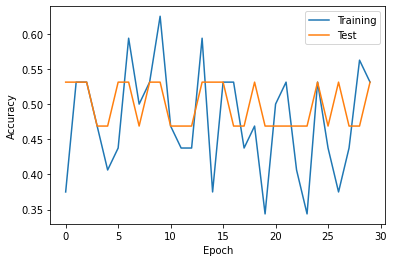

In [29]:
plt.plot(epoch_accuracy, label="Training")
plt.plot(testing_accuracy, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

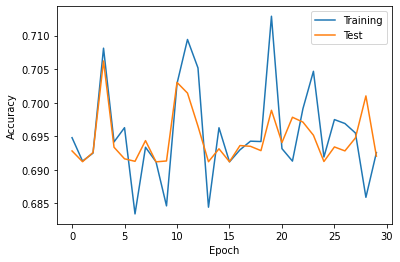

In [30]:
import numpy as np

plt.plot(np.array(epoch_loss), label="Training")
plt.plot(np.array(testing_loss), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Where to go from here
Follow us on [LinkedIn](https://www.linkedin.com/company/mlnuggets), [Twitter](https://twitter.com/ml_nuggets), [GitHub](https://github.com/mlnuggets) and subscribe to our [blog](https://www.machinelearningnuggets.com/#/portal) so that you don't miss a new issue.